# Erstanalyse Motoren-Spezifikationen

Dieses Notebook ist eine Unterlage für  https://www.meetup.com/Lerngruppe-NLP-NLU/events/272505065/.

Zielgruppe sind Teilnehmer an diesem Meetup.

## Vorbereitung

Siehe [README.md](README.md).

## Python Crash Kurs

Um den Quellcode auch für Einsteiger besser nachvollziebahr zu machen, hier ein paar Python-Basics, die im folgenden verwendet werden.

In [1]:
# Strings
name = "Bob"

greeting = "Hello " + name               # "Hello Bobo"
farewell = f"Good bye, {name}!"          # "Good bye, Bob!"


# Number and math: just like you expect.


# Lists
names = ["Bob", "Alice", "Joe", "Sue"]


for name in names:
    print(name)

Bob
Alice
Joe
Sue


Access items by index (starting with 0; -1 = last entry, -2=last but one, ...):

In [2]:
names[1]

'Alice'

In [3]:
names[-1]

'Sue'

Alle Einträge eines Wörterbuchs anzeigen:

In [4]:
# Dictionaries (maps)
name_to_phone_map = {
    "Bob": "0650/1234567",
    "Alice": "0664/9876543",
    "Joe": "0699/24680"
}

for name, phone in name_to_phone_map.items():
    print(name, phone)

Bob 0650/1234567
Alice 0664/9876543
Joe 0699/24680


Einen Eintrag auslesen:

In [5]:
name_to_phone_map["Alice"]

'0664/9876543'

Einen neuen Eintrag hinzufügen:

In [6]:
name_to_phone_map["Sue"] = "0650/97531"

## Daten einlesen

Die Originaldaten liegen in einem Excel-Sheet von Helmut und sind auf 3 Reiter verteilt, wobei vorerst nur die jeweils erste Spalte interessant ist. Theoretisch könnte man sie mit z.B. [xlrd](https://pypi.org/project/xlrd/) einlesen. Hier biete es sich jedoch an, sie einfach händisch mit Kopieren und Einfügen in 3 Textdateien zu übertragen:

1. [nema_17f.txt](nema_17f.txt)
1. [nema_17f_Vorl2.txt](nema_17f_Vorl2.txt)
1. [rk_ii.txt](rk_ii.txt)

Diese Dateien können wir nun in Python-Listen einlesen und in einem Wörterbuch ("dictionary") ablegen. Mit `strip()` lassen sich Leerzeichen am Anfang und Ende einer Zeile entfernen. Leerzeilen filtern wir ganz weg.

In [7]:
text_names = ["nema_17f.txt", "nema_17f_Vorl2.txt", "rk_ii.txt"]
text_name_to_lines_map = {}
for text_name in text_names:
    lines = []
    with open(text_name, "r", encoding="utf-8") as text_file:
        for line in text_file:
            line = line.rstrip("\n").strip()
            if line != '':
                lines.append(line)
    text_name_to_lines_map[text_name] = lines   

# Show the lines for "nema_17f.txt".
print(text_name_to_lines_map["nema_17f.txt"])

['Nema 17', 'Quick Reference', 'NEMA size 17 1.8° 2-phase stepper motor', 'Mechanical Specifications', 'Dimensions in inches (mm)', 'Optional rear shaft', 'Flat extends to rear end bell', 'Notes and Warnings', 'Installation, configuration and maintenance must be carried out by qualified technicians only', 'You must have detailed information to be able to carry out this work.', 'Unexpected dangers may be encountered when working with this product!', 'Incorrect use may destroy this product and connected components!', 'For more information, go to www.imshome.com', 'Specifications_x000D_', '1.5 Amp motors', 'Single length', 'Double length', 'Triple length', 'Part number', 'Holding torque oz-in N-cm', 'Detent torque oz-in  N-cm', 'Rotor inertia oz-in-sec2 kg-cm2', 'Weight oz  grams', 'Phase current amps', 'Phase resistance ohms', 'Phase inductance mH', 'FRONT VIEW', 'REAR VIEW (Reduced)', 'Motor stack length inches (mm)', 'Wiring and Connections', 'Signals and wire colors', 'Phase A Red', '

Wir können auch alle Zeilen zu einer langen Liste von Zeilen verknüpfen:

In [8]:
all_lines = []
for lines in text_name_to_lines_map.values():
    all_lines.extend(lines)
    
# How many lines do we have in total?
len(all_lines)

136

Bei Listen fügt `append()` ein Element hinzu, während `extend` alle Elemente einer Liste hinzufügt.

## Wortwolken

Zuerst sammeln wir alle Zeilen unserer Texte in einer langen Zeichenkette:

In [9]:
all_text = '\n'.join(all_lines)

Now let's generate the word cloud and display it as an image:

In [10]:
from wordcloud import WordCloud


def color(*args, **kwargs):
    return 'black'


news_cloud = WordCloud(
    width=800, height=400,
    background_color='white', 
    color_func=color
).generate(all_text)

Now convert the word cloud to an image and render it using `mathplotlib`:

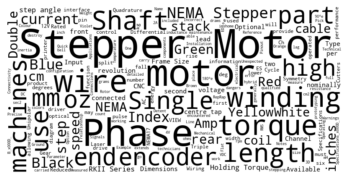

In [11]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.rcParams['figure.figsize'] = [16, 8]
plt.imshow(news_cloud, interpolation='bilinear')

Sadly this looks pretty pointless because all the words emphasized are generic German word unrelated to the actual topics the articles are about.

## Stop words

Fortunately there is a memachnism to deal with this: stop words.

Stop words are removed from processing and typically include the most common words of a language. `WordCloud` actually does have a parameter to specify such words. We could just specify a list and hope to get most of them.

However, spacy already includes such a list:

In [12]:
import spacy
nlp_en = spacy.load('en_core_web_sm')

In [13]:
stop_words_en = nlp_en.Defaults.stop_words
sorted(stop_words_en)[:20]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also']

Also noch einmal ohne Stopwörter, und dabei auch alles in Kleinschrift (mit `lower()`):

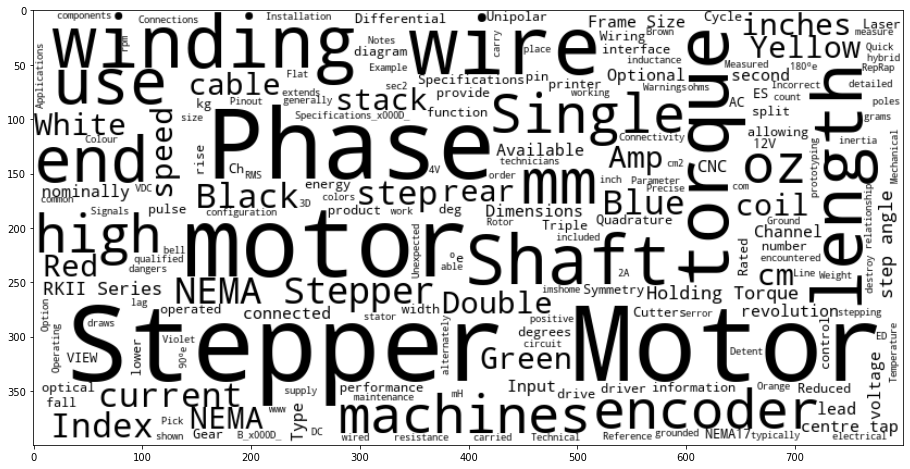

In [14]:
news_cloud_without_stop_words = WordCloud(
    width=800, height=400,
    background_color='white', 
    color_func=color,
    stopwords=stop_words_en
).generate(all_text)
plt.imshow(news_cloud_without_stop_words, interpolation='bilinear')

## Satzanalyse

Unsere Texte sind teilweise ganze Sätze, teilweise einige wenigt Wörter wie Tabellenüberschriften.

Eine einfache Heuristic, um Sätze zu erkennen:
1. Endet mit ".", "!" oder "?"
1. Hat mehr als 40 Zeichen
1. Hat höchstens 40 Zeichen aber keine Zahlen.
Damit lässt sich ein Mapping der Zeilen in unserem Dokumenten erstellen:

In [15]:
import re  # regular expressions

text_name_to_cleaned_lines = {}
for text_name, lines in text_name_to_lines_map.items():
    cleaned_lines = []
    for line in lines:
        is_sent = (
            len(line) >= 30 
            or line.endswith(".")
            or line.endswith("!")
            or line.endswith("?")
            #or not re.match(r"\d", line)
        )
        if is_sent:
            if line[-1] not in ".!?":
                line += "."
            cleaned_lines.append(line)
    text_name_to_cleaned_lines[text_name] = cleaned_lines
    

text_name_to_cleaned_lines["nema_17f.txt"]

['NEMA size 17 1.8° 2-phase stepper motor.',
 'Installation, configuration and maintenance must be carried out by qualified technicians only.',
 'You must have detailed information to be able to carry out this work.',
 'Unexpected dangers may be encountered when working with this product!',
 'Incorrect use may destroy this product and connected components!',
 'For more information, go to www.imshome.com.',
 'Rotor inertia oz-in-sec2 kg-cm2.',
 'Motor stack length inches (mm).',
 'Stepper motor frame size M - 17  =  NEMA 17 (1.7” / 42 mm).',
 'Motor length 13 -  =  single stack 15 -  =  double stack 19 -  =  triple stack.',
 'Shaft S = single, front shaft only D = double, front and rear shafts.',
 'ES = Single-end ED = Differential.',
 'Speed in full steps per second (rpm).',
 'wire 1   Brown   2   Violet   3   Blue  4 Orange   5   Yellow.',
 'Ground      Index     Channel A    +5 VDC input Channel B_x000D_.',
 'optional interface cable available: ES-CABLE-2.',
 'Index rise (after Ch A 

Das Ergebnis ist zwar nicht perferkt, aber für's erste gut genug.

Nun können wir uns z.B. die erste 5 Sätze als einen langen Text zusammenfassen:

In [16]:
text = " ".join(text_name_to_cleaned_lines["nema_17f.txt"][:5])
text

'NEMA size 17 1.8° 2-phase stepper motor. Installation, configuration and maintenance must be carried out by qualified technicians only. You must have detailed information to be able to carry out this work. Unexpected dangers may be encountered when working with this product! Incorrect use may destroy this product and connected components!'

Als nächstes machen wir aus diesem Satz ein ganzes Dokument, das spaCy analysieren kann:

In [17]:
doc = nlp_en(text)

Und diesen Text nun (mit spaCy) wieder in Sätze zerlegen:

In [18]:
for sent in doc.sents:
    print(sent)

NEMA size 17 1.8° 2-phase stepper motor.
Installation, configuration and maintenance must be carried out by qualified technicians only.
You must have detailed information to be able to carry out this work.
Unexpected dangers may be encountered when working with this product!
Incorrect use may destroy this product and connected components!


Sehen wir uns den zweiten Satz genauer an:

In [19]:
# NOTE: doc.sents is a sequence we can only iterate over,
#       so we first have to convert it to a list to access
#       specific items per index.

first_sent = list(doc.sents)[1]
print(first_sent)

Installation, configuration and maintenance must be carried out by qualified technicians only.


Ein Satz ist eine folge von Token:

In [20]:
for token in first_sent:
    print(token)

Installation
,
configuration
and
maintenance
must
be
carried
out
by
qualified
technicians
only
.


Sehen wir uns ein Token genauer an:

In [21]:
special_token = list(first_sent)[10]
special_token

qualified

Für die reine Ausgabe sieht ein Token wie eine Zeichenkette aus. Tatsächlich ist es ein Object mit Eigenschaften, wobei hier einige der spannenderen kurz beschrieben sind. Eine vollständige Beschreibung ist verügbar unter <https://spacy.io/api/token>.

In [22]:
# The token as text
special_token.text

'qualified'

Schnelle Umwandlung in Kleinschreibung:

In [23]:
special_token.lower_

'qualified'

Zur Rückführung auf das Stammwort:

In [24]:
# The stem word of the token
special_token.lemma_

'qualified'

Es gibt ettliche Eigenschaften um die Art des Tokens zu prüfen, z.B. `is_lower`, `is_punct`(puntuation), `like_num` (true for 10, 10.0 or ten) or `like_email`.

## Token performance

Zahlreiche Eigenschaften von Token haben zwei Darstellungen: eine menschlich lesbare als Zeichenkette, oder eine interne Kennung als Zahl. Letztere ist zwar schwieriger zu verdauer, dafür deutlich schneller zu verarbeiten (da intern nur eine Zahl):

In [25]:
special_token.lemma, special_token.lemma_

(4416020510660890727, 'qualified')

In [26]:
special_token.lower, special_token.lower_

(4416020510660890727, 'qualified')

In general, use the numeric representation for comparing tokens or storing them in a list in memory, and the text representation for printing or persistently storing in a file or database.

## Part of speech (POS) tagging
The `pos` attribute describes the role of a token in the sent, for example noun, verb, adjective. There also is a more detailed variant in `tag`.

In [27]:
for token in first_sent:
    print(f'{token.text:20} {token.pos_:10} {token.tag_:10}')

Installation         NOUN       NN        
,                    PUNCT      ,         
configuration        NOUN       NN        
and                  CCONJ      CC        
maintenance          NOUN       NN        
must                 VERB       MD        
be                   AUX        VB        
carried              VERB       VBN       
out                  ADP        RP        
by                   ADP        IN        
qualified            ADJ        JJ        
technicians          NOUN       NNS       
only                 ADV        RB        
.                    PUNCT      .         


The various constants can be accessed or resolved using `spacy.symbols`:

In [28]:
from spacy import symbols
print(f'numeric code for ADJ is {symbols.ADJ}')
print(f'name ADJ resolves to numeric code {symbols.IDS["ADJ"]}')
print(f'name of {symbols.ADJ} is {symbols.NAMES[symbols.ADJ]}')

numeric code for ADJ is 84
name ADJ resolves to numeric code 84
name of 84 is ADJ


# Wortanzahlen

In [29]:
all_text = ""
for lines in text_name_to_lines_map.values():
    all_text += " ".join(lines)

all_lemmas = []
for token in nlp_en(all_text):
    all_lemmas.append(token.lemma_)

Nun können wir zählen, welche Lemmas to häufigsten sind:

In [30]:
from collections import Counter
Counter(all_lemmas).most_common(10)

[('.', 30),
 (',', 28),
 ('be', 28),
 ('and', 24),
 ('-', 20),
 ('motor', 19),
 ('the', 19),
 ('(', 18),
 ('in', 17),
 (')', 16)]

Das ist weniger spannend, daher nochmals ohne Stoppwörter und Punktierung:

In [31]:
all_lemmas = []
for token in nlp_en(all_text):
    lemma = token.lemma_
    if (lemma not in stop_words_en) and (token.pos != symbols.PUNCT) and (lemma.strip() != ''):
        all_lemmas.append(lemma)
        
Counter(all_lemmas).most_common(10)

[('motor', 19),
 ('Stepper', 13),
 ('17', 11),
 ('Motor', 11),
 ('NEMA', 9),
 ('wire', 9),
 ('-PRON-', 8),
 ('use', 8),
 ('torque', 8),
 ('Phase', 8)]